In [8]:
!pip install requests tensorflow scikit-learn

In [9]:
# --- 0. Imports ---
import pandas as pd
import numpy as np
import requests, zipfile, io
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [10]:
# --- 1. Download & extract dataset ---
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip"
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()  # Extracts: 'household_power_consumption.txt'

In [11]:
# --- 2. Load and preprocess raw data ---
df = pd.read_csv(
    'household_power_consumption.txt',
    sep=';',
    na_values=['?'],
    low_memory=False
)
df['dt'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')
df.set_index('dt', inplace=True)
df = df[['Global_active_power']].dropna()

In [12]:
# --- 3. Proper hourly resampling + gap-filling ---
df = df.sort_index()
hourly = df.resample('h').mean()
hourly = hourly.asfreq('h')  # fill missing hours in index
hourly = hourly.interpolate(method='time', limit_direction='both')
hourly['hour'] = hourly.index.hour
hourly['dayofweek'] = hourly.index.dayofweek
print("Missing after fill:\n", hourly.isna().sum())

Missing after fill:
 Global_active_power    0
hour                   0
dayofweek              0
dtype: int64


In [13]:
# --- 4. Scale all features ---
scaler = MinMaxScaler()
scaled = scaler.fit_transform(hourly)

In [14]:
# --- 5. Create sequences for LSTM ---
SEQ_LEN = 24  # Use past 24 hours
def make_seq(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])         # input: full feature window
        y.append(data[i+seq_len][0])        # target: only power (first column)
    return np.array(X), np.array(y)

X, y = make_seq(scaled, SEQ_LEN)

In [15]:
# --- 6. Train-test split ---
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [16]:
from tensorflow.keras import Input

# --- 7. Build the LSTM model (clean version) ---
model = Sequential([
    Input(shape=(SEQ_LEN, 3)),         # 👈 Define input shape here
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

In [17]:
# --- 8. Train the model ---
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32
)

Epoch 1/20
865/865 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0170 - val_loss: 0.0068
Epoch 2/20
865/865 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0104 - val_loss: 0.0064
Epoch 3/20
865/865 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0097 - val_loss: 0.0061
Epoch 4/20
865/865 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0090 - val_loss: 0.0059
Epoch 5/20
865/865 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0085 - val_loss: 0.0060
Epoch 6/20
865/865 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0087 - val_loss: 0.0060
Epoch 7/20
865/865 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0086 - val_loss: 0.0059
Epoch 8/20
865/865 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0086 - val_loss: 0.0059
Epoch 9/20
865/865 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0084 - val_loss: 0.0059
Epoch 10/20
865/865 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0082 - val_loss: 0.0057
Epoch 11/20
865/865 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0082 - val_loss: 0.0057
Epoch 12/20
865/865 ━━━━━━━━━━━━━━━━━━━━ 10s 

In [18]:
# --- 9. Predict and evaluate ---
pred_scaled = model.predict(X_test)
pred = scaler.inverse_transform(np.hstack([pred_scaled, X_test[:, -1, 1:]]))[:, 0]  # inverse-transform just power
actual = scaler.inverse_transform(np.hstack([y_test.reshape(-1,1), X_test[:, -1, 1:]]))[:, 0]

217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [19]:
# 10. Compute accuracy metrics
mse  = mean_squared_error(actual, pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(actual, pred)

print(f"\n✅ Final Accuracy:")
print(f"Test MSE : {mse:.4f}")
print(f"Test RMSE: {rmse:.4f} kW")
print(f"Test MAE : {mae:.4f} kW")


✅ Final Accuracy:
Test MSE : 0.2418
Test RMSE: 0.4917 kW
Test MAE : 0.3465 kW


In [20]:
# -------- SGO MODEL --------

In [21]:
pip install numpy pandas

In [23]:
import numpy as np
import pandas as pd

# Assume predicted demand for 24 hours (kW)
pred_scaled = model.predict(X_test)
# Manually reverse the MinMax scaling for just 1 feature
min_val = scaler.data_min_[0]   # only the first column was predicted
max_val = scaler.data_max_[0]
predicted_demand = pred_scaled.flatten() * (max_val - min_val) + min_val
predicted_demand = predicted_demand[:24]

# Assume renewable availability (kW): solar peaks in day, zero at night
renewable_avail = np.array([
    0.0, 0.0, 0.1, 0.3, 0.6, 1.5, 2.5, 3.0,
    3.2, 3.5, 3.7, 4.0, 3.5, 3.0, 2.5, 1.8,
    1.0, 0.5, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0
])

# Carbon emissions (arbitrary units): 0 for renewables, 1.0 for non-renewables
COST_PER_KW_RENEW = 0.05
COST_PER_KW_NONRENEW = 0.15
EMISSIONS_NONRENEW = 1.0  # emissions per kW

217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [26]:
optimal_mix = []

total_cost = 0
total_emissions = 0

for hour in range(24):
    demand = predicted_demand[hour]
    renewable_used = min(demand, renewable_avail[hour])
    nonrenewable_needed = demand - renewable_used

    hour_cost = (renewable_used * COST_PER_KW_RENEW) + (nonrenewable_needed * COST_PER_KW_NONRENEW)
    hour_emissions = nonrenewable_needed * EMISSIONS_NONRENEW

    total_cost += hour_cost
    total_emissions += hour_emissions

    optimal_mix.append({
        'hour': hour,
        'demand_kW': demand,
        'renewable_used_kW': renewable_used,
        'nonrenewable_kW': nonrenewable_needed,
        'hour_cost_$': hour_cost,
        'hour_emissions': hour_emissions
    })

df_mix = pd.DataFrame(optimal_mix)
print(df_mix)
print(f"\nTotal Cost: ${total_cost:.2f}")
print(f"Total Emissions: {total_emissions:.2f} units")

    hour  demand_kW  renewable_used_kW  nonrenewable_kW  hour_cost_$  \
0      0   1.830292           0.000000         1.830292     0.274544   
1      1   0.595521           0.000000         0.595521     0.089328   
2      2   0.356789           0.100000         0.256789     0.043518   
3      3   0.303273           0.300000         0.003273     0.015491   
4      4   0.271273           0.271273         0.000000     0.013564   
5      5   0.258433           0.258433         0.000000     0.012922   
6      6   0.568320           0.568320         0.000000     0.028416   
7      7   0.366855           0.366855         0.000000     0.018343   
8      8   0.463355           0.463355         0.000000     0.023168   
9      9   0.876496           0.876496         0.000000     0.043825   
10    10   2.067196           2.067196         0.000000     0.103360   
11    11   2.142777           2.142777         0.000000     0.107139   
12    12   1.433289           1.433289         0.000000     0.07

In [29]:
# Use your LSTM model to predict demand
pred_scaled = model.predict(X_test)

# Manually inverse-transform ONLY the first feature (Global_active_power)
min_val = scaler.data_min_[0]   # min for the first column
max_val = scaler.data_max_[0]   # max for the first column

# Reverse scaling manually
predicted_demand = pred_scaled.flatten() * (max_val - min_val) + min_val

# Take only the first 24 hours for Smart Grid Optimizer
predicted_demand = predicted_demand[:24]

217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [30]:
# Constants
CO2_PER_KWH_NONRENEW = 0.92

# Emissions calc
baseline_emissions = sum(predicted_demand) * CO2_PER_KWH_NONRENEW
optimized_emissions = sum(df_mix['nonrenewable_kW']) * CO2_PER_KWH_NONRENEW
emissions_saved = baseline_emissions - optimized_emissions
percent_saved = (emissions_saved / baseline_emissions) * 100

# Real-world equivalence
kg_per_mile = 0.404
trees_absorb_per_year = 21
miles_avoided = emissions_saved / kg_per_mile
trees_equiv = emissions_saved / trees_absorb_per_year

# Display
print("\n=== Emissions Report ===")
print(f"Baseline emissions     : {baseline_emissions:.2f} kg CO₂")
print(f"Optimized emissions    : {optimized_emissions:.2f} kg CO₂")
print(f"Emissions saved        : {emissions_saved:.2f} kg CO₂")
print(f"Percent reduction      : {percent_saved:.2f}%")
print(f"Equivalent to avoiding : {miles_avoided:.0f} car miles")
print(f"Equivalent to planting : {trees_equiv:.1f} trees")



=== Emissions Report ===
Baseline emissions     : 27.06 kg CO₂
Optimized emissions    : 12.26 kg CO₂
Emissions saved        : 14.81 kg CO₂
Percent reduction      : 54.72%
Equivalent to avoiding : 37 car miles
Equivalent to planting : 0.7 trees


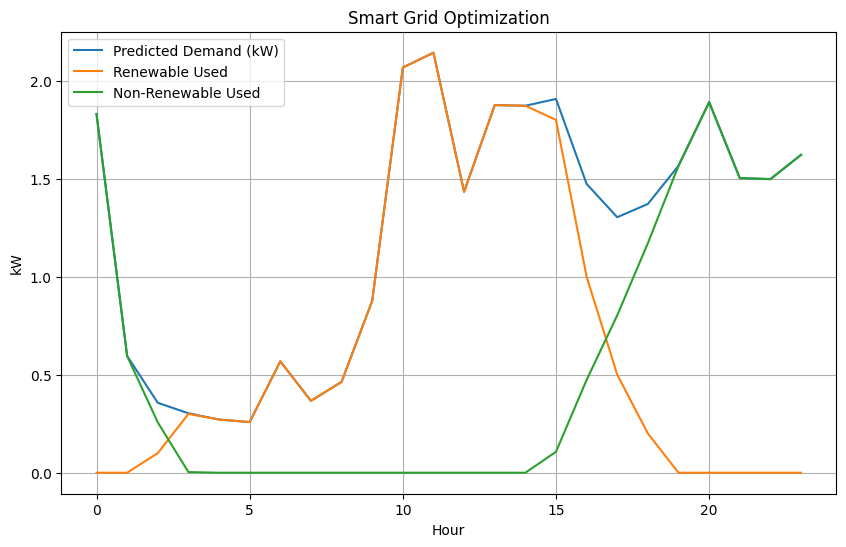

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(predicted_demand, label='Predicted Demand (kW)')
plt.plot(df_mix['renewable_used_kW'], label='Renewable Used')
plt.plot(df_mix['nonrenewable_kW'], label='Non-Renewable Used')
plt.title('Smart Grid Optimization')
plt.xlabel('Hour')
plt.ylabel('kW')
plt.legend()
plt.grid(True)
plt.show()